In [ ]:
"""
Initial feature list:
- patients with diabetes
- ?? active patients only
- update create tables

1. HBA1c
2. age
3. IMD
4. gender
5. ethnicity
6. diabetic endpoints - amputation, cardiac disease, retinopathy, ketoacidosis, ESRF, gastroparesis, neuropathy, PVD/circulatory disorder
7. medication - insulin, glp1, sulphonylurea
8. medication compliance
"""

'\nInitial feature list:\n- patients with diabetes\n- ?? active patients only\n- update create tables\n \n1. HBA1c\n2. age\n3. IMD\n4. gender\n5. ethnicity\n6. diabetic endpoints - amputation, cardiac disease, retinopathy, ketoacidosis, ESRF, gastroparesis, neuropathy, PVD/circulatory disorder\n7. medication - insulin, glp1, sulphonylurea\n8. medication compliance\n'

In [ ]:
"""
Definitions made:

- non type 1 diabetes
- lower limb amputation
- MI
- stroke
- heart failureÍ
- retinopathy/eye disease
- dka
- renal disorder due to T2DM
- neuropathy/gastroparesis
- PVD

definitions to do:
[x] hba1c
[ ] medications
"""

'\ndefinitions made:\n\n- non type 1 diabetes\n- lower limb amputation\n- MI\n- stroke\n- heart failureÍ\n- retinopathy/eye disease\n- dka\n- renal disorder due to T2DM\n- neuropathy/gastroparesis\n- PVD\n\ndefinitions to do:\n[x] hba1c\n[ ] medications\n'

In [ ]:
"""
UPDATED FEATURE LIST
Need to do an hba1c diagnosis Vs code diagnosis at some point.

Factors to predict future hba1c:
- age at prediction point 
- Insulin and compliance with it
- Metformin and compliance 
- Etc for other meds 
- BMI
- BMI increase rate
- Last egfr
- Sex
- Ethnicity 
- Age at first diabetic hba1c/diagnosis 
- The various endpoints I defined as flags as binaries
- Number of hba1cs?
- Rate of increase?
- Time since last hba1c
- Most recent blood pressure
- IMD
- Diabetic medicine count
- Overall drug count/polypharmacy?
- BMI at first diagnosis?
- Time since diagnosis
- Rate of change in HbA1c in different time periods??
- Time since last HbA1c?

-> Should do outcomes (bad events, admissions) for the outcome period and show that hba1c correlates and can predict these.
"""

In [ ]:
from dotenv import load_dotenv, dotenv_values
from phmlondon.snow_utils import SnowflakeConnection
from phmlondon.feature_store_manager import FeatureStoreManager
import os
import marimo as mo
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
load_dotenv('.env') # very weirdly, marimo changes the default behaviour of load_dotenv to look next to pyproject.toml first rather than in the cwd, so need to specify - https://docs.marimo.io/guides/configuration/runtime_configuration/#env-files
conn = SnowflakeConnection()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/8076439c-5b1f-4e15-91ea-a0bff0b3bf16/saml2?SAMLRequest=nZJRb5swEMe%2FCvKewYYATawkFUvWDalroyad2r4ZMKkXYzOfKUk%2F%2FRzSSN1D%2BzDJD9b5f%2Bff3f%2Bml%2FtGei%2FcgNBqhsKAII%2BrUldCbWfofnPlj5EHlqmKSa34DB04oMv5FFgjW5p19lnd8T8dB%2Bu5Qgro8DBDnVFUMxBAFWs4UFvSdfbzmkYBoa3RVpdaoncpn2cwAG6sIzynVCAc3rO1LcW47%2FugHwXabHFECMFkgp3qKPly1u9dTx%2FoQ0zio94pnHz1xvZVqNMIPsMqTiKgPzablb%2B6XW%2BQl51RF1pB13Cz5uZFlPz%2B7voEAI5g%2FS1Jw3EadDsftJthwF47wwNQuq8l2%2FFSN21nXenA3XDNKyz1Vrju8%2BUMtTtRtZDsFxr67PXhd1Gw%2FFBf55k4xN8fS%2Ft403QPprl92h9cF9sSeb%2FO9kZHe3OAjufqaKp1IRIlPnEn3YQxHSU0joL0gjwhb%2BlMFYrZIfNMPnAEjSiNBl1braRQfKAck4s0Hk1KPynC2o95mPiTkDOfkaKuSTEq6jDFR6sjdFofOoCY%2BX8NZYrfl3hbxxvnUL5caSnKg3elTcPsxwaGQThEROXXg5TyhgmZVZXhAM5IKXW%2FMJ

Snowflake session created successfully.


In [ ]:
DATABASE = "INTELLIGENCE_DEV"
SCHEMA = "AI_CENTRE_FEATURE_STORE"
METADATASCHEMA = "AI_CENTRE_FEATURE_STORE_METADATA"
feature_store_manager = FeatureStoreManager(conn, DATABASE, SCHEMA, METADATASCHEMA)

Using database: INTELLIGENCE_DEV


Using schema: AI_CENTRE_FEATURE_STORE


In [ ]:
# Create feature

with open('create_tables/all_hba1c_with_custom_def.sql') as fid:
    query = fid.read()
    # data = conn.session.sql(sql).collect()

feature_store_manager.add_new_feature(
    feature_name="HbA1c_with_unit_reallocation",
    feature_desc=""""
        HbA1cs selected using a custom definition which pulls out any SNOMED code in our database that looks like an Hba1c and where results have been allocated to a significant proportion of the entries. Results are cleaned - the ones that look like they may be old units are converted to mmol/mol (see units for more).
        """,
    feature_format="Continuous",
    sql_select_query_to_generate_feature=query, 
    existence_ok=True)

Using schema: AI_CENTRE_FEATURE_STORE_METADATA


['IMD2019LONDON', 'PERSON_MASTER_INDEX']


Using schema: AI_CENTRE_FEATURE_STORE
Feature HBA1C_WITH_UNIT_REALLOCATION, ID 2cd0e53a-110c-448a-a4c3-19a04a717595, added to the feature registry; table not created yet


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE


Table HBA1C_WITH_UNIT_REALLOCATION_v1 created successfully
with hba1cs as (
    select o.*, c.name
    from prod_dwh.analyst_primary_care.observation as o
    join prod_dwh.analyst_primary_care.concept as c
    on o.core_concept_id = c.dbid
    join intelligence_dev.ai_centre_definition_library.definitionstore as ds
    on c.code = ds.code
    where ds.definition_id = '1aa77156'
    -- and o.person_id = 51490
),
corrected_hba1cs as (
    select *,
        CASE
            WHEN result_value BETWEEN 4 AND 15 THEN '%'
            WHEN result_value BETWEEN 19 and 140 THEN 'mmol/mol'
            ELSE 'invalid'
        END AS result_value_inferred_units,
        CASE
            WHEN result_value BETWEEN 4 and 15 THEN ROUND((result_value*10.93) - 23.5, 2)
            WHEN result_value BETWEEN 19 and 140 THEN result_value
            ELSE NULL -- invalid values set to null
        END AS result_value_cleaned_and_converted_to_mmol_per_mol
    from hba1cs),
tidied_values as (
    select person_

Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE
Feature 2cd0e53a-110c-448a-a4c3-19a04a717595 version 1 added to the feature version registry


In [ ]:
"""
HbA1c analysis:
- how many HbA1cs do we have?
- how many patients have a repeated HbA1c?
- what's the avergae number of HbA1cs, average frequency, average time between? 
- do HbA1cs tend to get better or worse and by how much and over how long?
"""

"\nHbA1c analysis:\n- how many HbA1cs do we have?\n- how many patients have a repeated HbA1c?\n- what's the avergae number of HbA1cs, average frequency, average time between? \n- do HbA1cs tend to get better or worse and by how much and over how long?\n"

In [ ]:
# Explore HbA1cs
hba1cs = conn.session.sql("""
    select PERSON_ID, RESULT_VALUE_CLEANED_AND_CONVERTED_TO_MMOL_PER_MOL
    from INTELLIGENCE_DEV.AI_CENTRE_FEATURE_STORE.HBA1C_WITH_UNIT_REALLOCATION_V1;
    """).to_pandas()


In [ ]:
print(f"Number of HbA1c readings: {len(hba1cs) :,}")

Number of HbA1c readings: 10,637,430


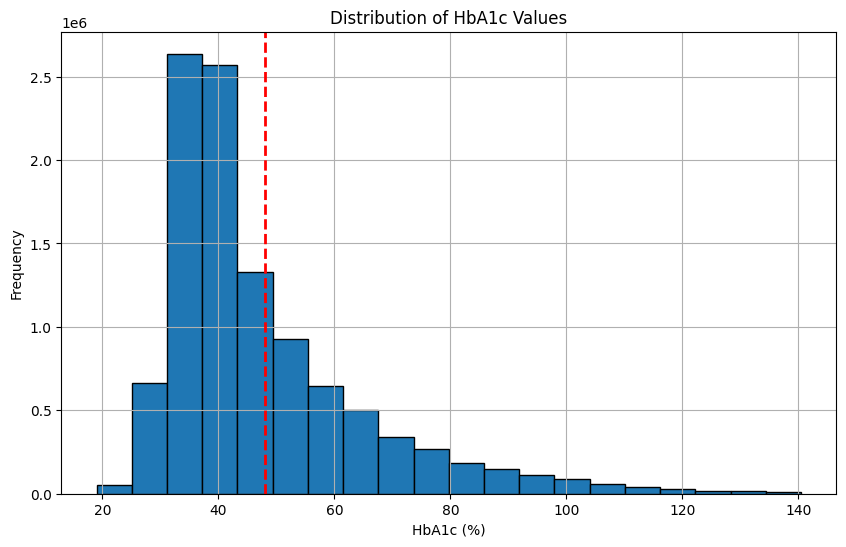

In [ ]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(hba1cs['RESULT_VALUE_CLEANED_AND_CONVERTED_TO_MMOL_PER_MOL'], bins=20, edgecolor='black')
plt.title('Distribution of HbA1c Values')
plt.xlabel('HbA1c (%)')
plt.ylabel('Frequency')
plt.axvline(x=48, color='red', linestyle='dashed', linewidth=2, label='48 mmol/mol')
plt.grid(True)
plt.show()


In [ ]:
readings_per_person = conn.session.sql(
    """
    SELECT 
    COUNT(*) AS total_readings,
    COUNT(DISTINCT person_id) AS unique_people,
    COUNT(*) * 1.0 / COUNT(DISTINCT person_id) AS avg_readings_per_person
    FROM INTELLIGENCE_DEV.AI_CENTRE_FEATURE_STORE.HBA1C_WITH_UNIT_REALLOCATION_V1;
    """).to_pandas()
print(readings_per_person)

   TOTAL_READINGS  UNIQUE_PEOPLE  AVG_READINGS_PER_PERSON
0        10637430        1682251                        6


457,944 patients have exactly one HbA1c reading.
263,241 patients have more than 10 HbA1c readings.


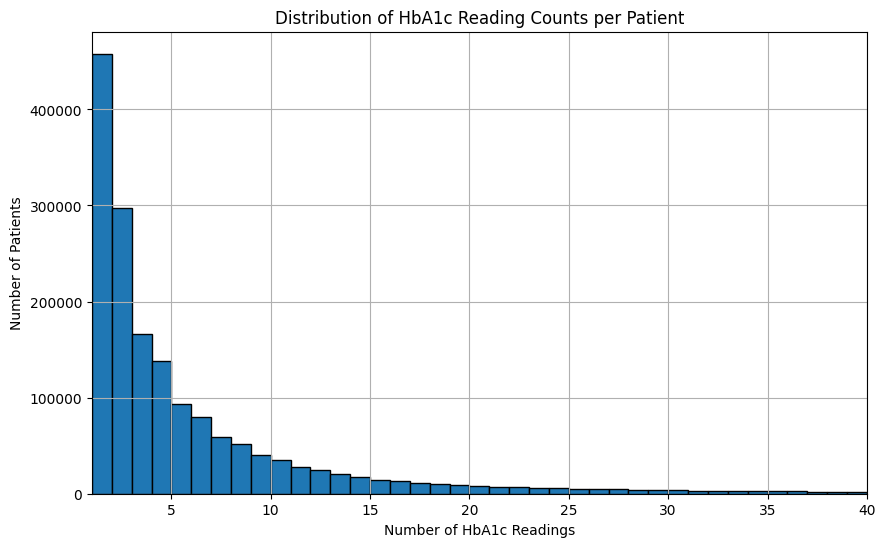

In [ ]:
reading_counts = hba1cs['PERSON_ID'].value_counts()
num_with_one = (reading_counts == 1).sum()
print(f"{num_with_one:,} patients have exactly one HbA1c reading.")
num_more_than_ten = (reading_counts >10).sum()
print(f"{num_more_than_ten:,} patients have more than 10 HbA1c readings.")

# Plot histogram of the counts
plt.figure(figsize=(10, 6))
plt.hist(reading_counts, bins=range(1, reading_counts.max() + 2), edgecolor='black')
plt.title('Distribution of HbA1c Reading Counts per Patient')
plt.xlabel('Number of HbA1c Readings')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.xlim(1, 40)
plt.show()



In [ ]:
timelags = conn.session.sql("""
    WITH dated_diffs AS (
    SELECT
        person_id,
        CLINICAL_EFFECTIVE_DATE,
        LAG(CLINICAL_EFFECTIVE_DATE) OVER (
            PARTITION BY person_id 
            ORDER BY CLINICAL_EFFECTIVE_DATE
        ) AS prev_date
    FROM INTELLIGENCE_DEV.AI_CENTRE_FEATURE_STORE.HBA1C_WITH_UNIT_REALLOCATION_V1
),
time_differences AS (
    SELECT
        person_id,
        DATEDIFF(DAY, prev_date, CLINICAL_EFFECTIVE_DATE) AS days_between
    FROM dated_diffs
    WHERE prev_date IS NOT NULL
)
SELECT
    person_id,
    AVG(days_between) AS avg_days_between_readings
FROM time_differences
GROUP BY person_id;""").to_pandas()



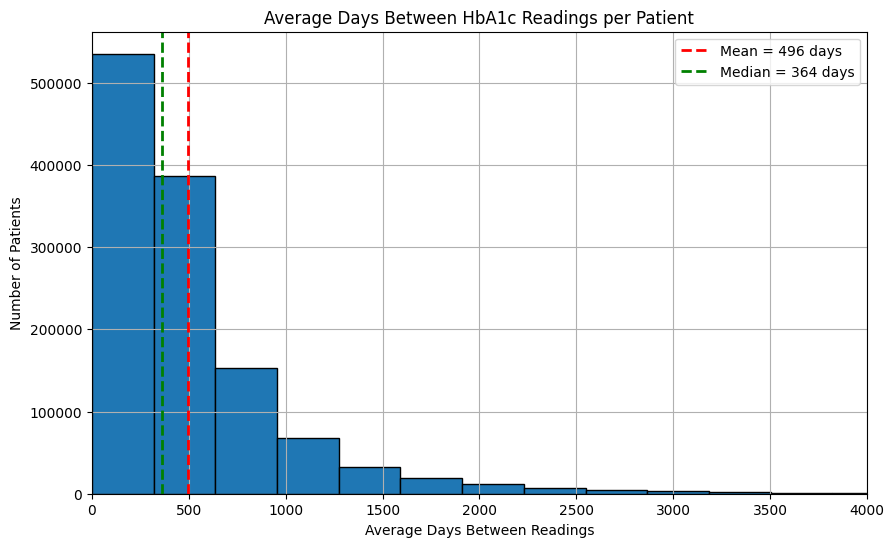

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(timelags['AVG_DAYS_BETWEEN_READINGS'], bins=30, edgecolor='black')
plt.title('Average Days Between HbA1c Readings per Patient')
plt.xlabel('Average Days Between Readings')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.xlim(0, 4000)

mean_val = timelags['AVG_DAYS_BETWEEN_READINGS'].mean()
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_val:.0f} days')

median_val = timelags['AVG_DAYS_BETWEEN_READINGS'].median()
plt.axvline(median_val, color='green', linestyle='dashed', linewidth=2, label=f'Median = {median_val:.0f} days')

plt.legend()

plt.show()

In [ ]:
# Filter for patients with an average of 2 or fewer days between readings
patients_with_close_readings = timelags[timelags['AVG_DAYS_BETWEEN_READINGS'] <= 2]
num_patients = patients_with_close_readings['PERSON_ID'].nunique()
print(f"{num_patients:,} patients have an average of 2 or fewer days between HbA1c readings.")

105,041 patients have an average of 2 or fewer days between HbA1c readings.


In [ ]:
timelags['AVG_DAYS_BETWEEN_READINGS'].describe()


<marimo-table data-initial-value='[]' data-label='null' data-data='"[{\"\":\"count\",\"AVG_DAYS_BETWEEN_READINGS\":1224306.0},{\"\":\"mean\",\"AVG_DAYS_BETWEEN_READINGS\":495.62584145},{\"\":\"std\",\"AVG_DAYS_BETWEEN_READINGS\":501.1501772462},{\"\":\"min\",\"AVG_DAYS_BETWEEN_READINGS\":0.0},{\"\":\"25%\",\"AVG_DAYS_BETWEEN_READINGS\":196.083333},{\"\":\"50%\",\"AVG_DAYS_BETWEEN_READINGS\":363.875},{\"\":\"75%\",\"AVG_DAYS_BETWEEN_READINGS\":631.6},{\"\":\"max\",\"AVG_DAYS_BETWEEN_READINGS\":9556.0}]"' data-total-rows='8' data-total-columns='1' data-banner-text='""' data-pagination='true' data-page-size='10' data-field-types='[["AVG_DAYS_BETWEEN_READINGS", ["number", "float64"]]]' data-show-filters='true' data-show-download='true' data-show-column-summaries='false' data-row-headers='[""]' data-has-stable-row-id='false' data-lazy='false' data-preload='false'>

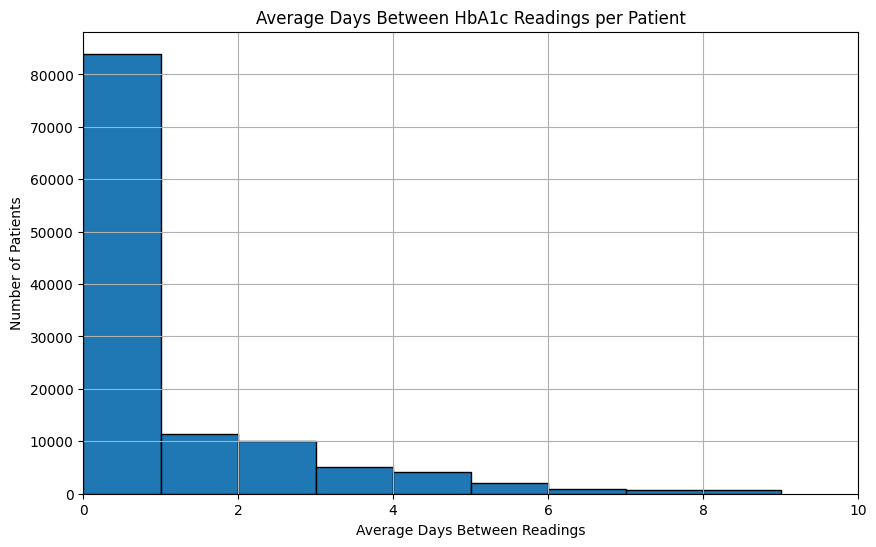

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(timelags['AVG_DAYS_BETWEEN_READINGS'], bins=range(0,10), edgecolor='black')
plt.title('Average Days Between HbA1c Readings per Patient')
plt.xlabel('Average Days Between Readings')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.xlim(0, 10)
plt.show()

In [ ]:
hba1c_changes = conn.session.sql(
    """
    WITH hba1c_changes AS (
    SELECT
        person_id,
        CLINICAL_EFFECTIVE_DATE,
        result_value_cleaned_and_converted_to_mmol_per_mol as hba1c_value,
        LAG(hba1c_value) OVER (PARTITION BY person_id ORDER BY CLINICAL_EFFECTIVE_DATE) AS prev_hba1c_value,
        LAG(CLINICAL_EFFECTIVE_DATE) OVER (PARTITION BY person_id ORDER BY CLINICAL_EFFECTIVE_DATE) AS prev_date
    FROM INTELLIGENCE_DEV.AI_CENTRE_FEATURE_STORE.HBA1C_WITH_UNIT_REALLOCATION_V1
)
SELECT
    person_id,
    clinical_effective_date,
    hba1c_value,
    prev_hba1c_value,
    prev_date,
    DATEDIFF(DAY, prev_date, CLINICAL_EFFECTIVE_DATE) AS days_between,
    (hba1c_value - prev_hba1c_value) / (NULLIF(DATEDIFF(DAY, prev_date, CLINICAL_EFFECTIVE_DATE), 0)/365.25) AS hba1c_change_per_year
FROM hba1c_changes
WHERE prev_hba1c_value IS NOT NULL
ORDER BY person_id, clinical_effective_date;
"""
).to_pandas()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/8076439c-5b1f-4e15-91ea-a0bff0b3bf16/saml2?SAMLRequest=nZJBb%2BIwEIX%2FSuQ9J3EIScECKha2gl3YRZBSiZtJHLBw7KzHIaW%2Fvk4AqXtoDyvlENlv5nueN4PH10I4Z6aBKzlEgYeRw2SqMi4PQ%2FScPLk95IChMqNCSTZEFwbocTQAWoiSjCtzlGv2t2JgHNtIAmkuhqjSkigKHIikBQNiUrIZLxek42FCAZg2FoduJRlwyzoaUxLfr%2Bvaq0NP6YPfwRj7uO9bVSP5hj4gyq8ZpVZGpUrcS17tmz5BBD7uNgirsITVrfA7l9cRfEXZX0VAZkmycld%2FNglyxvfXTZSEqmB6w%2FSZp%2Bx5vbgaAOtg8yOKg17sVScXlJ2hR98qzTyQqs4FPbFUFWVlbGvP%2Fvk5y3yhDtwObD4dovLEs2W5WearaL7e4d2bkZcZhZdL8vOljBeXNMTHyXomz8GvbbxdpsjZ3uPtNPHOASo2l02oxh7hTuRi%2Bz0kASZhl0TYC8Noh5ypDZVLatrKu%2FPWh1fwVCtQuVFScMlalz38EHfDfupG%2ByB3uyyI3H7AqEvxPs%2FxPtznQew30XXQdX1Ia0SP%2FmsoA%2F9ji9s6%2FrYJzacrJXh6cZ6ULqj5PMDAC9oTnrl5KyWsoFyMs0wzABukEKqeaEaN3XqjK4b80Z

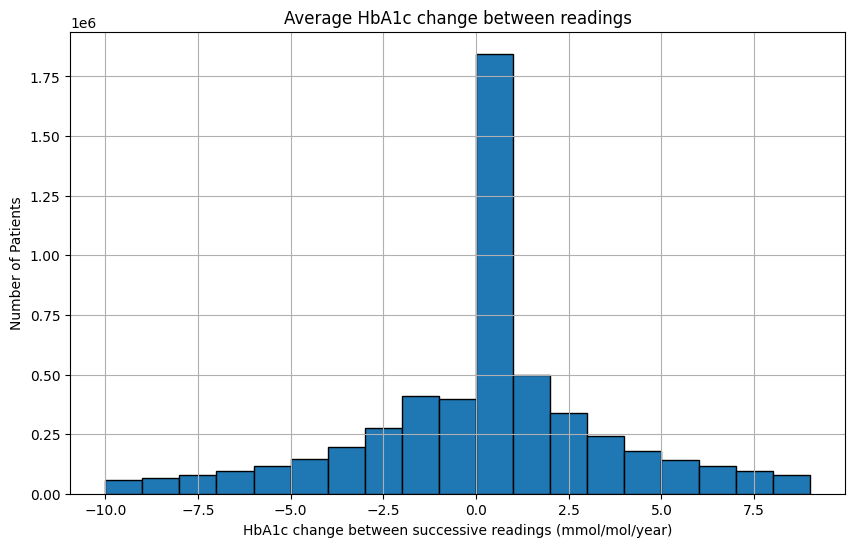

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(hba1c_changes["HBA1C_CHANGE_PER_YEAR"], bins=range(-10, 10), edgecolor='black')
plt.title('Average HbA1c change between readings')
plt.xlabel('HbA1c change between successive readings (mmol/mol/year)')
plt.ylabel('Number of Patients')
plt.grid(True)
plt.show()
# This is a heavily truncated part of the true distribution

In [ ]:
# now need to repeat these analyses for only patients with diabetes
# diagnosed by code
# 2 x HbA1c results >48 (see https://cks.nice.org.uk/topics/diabetes-type-2/diagnosis/diagnosis-in-adults/)
# include 'ever diagnosed' - i.e. don't remove if they get better. Rationale being (1) they might be on meds (2) we want the model to be able to predict people who get better
# At least 1 year of registration

In [ ]:
# Create feature

with open('create_tables/patients_with_nont1dm_codes_all_codes.sql') as _fid:
    _query = _fid.read()
    # data = conn.session.sql(sql).collect()

feature_store_manager.add_new_feature(
    feature_name="patients_with_non_t1dm_codes_all_instances",
    feature_desc=""""
        Patients who have a code matching the custom non-t1dm definition, including all the relevant codes
        """,
    feature_format="Categorical",
    sql_select_query_to_generate_feature=_query, 
    existence_ok=True)

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/8076439c-5b1f-4e15-91ea-a0bff0b3bf16/saml2?SAMLRequest=nZLBbuIwEIZfJfKeE9shgWAVKhZawW6hqKRdqTcnccBLYrMepyl9%2BjWhSN1De1gph8j5ZvJ5%2Frm6fq0r70UYkFqNEA0I8oTKdSHVdoQe01s%2FQR5YrgpeaSVG6CgAXY%2BvgNfVgU0au1MP4k8jwHqukQLWfRihxiimOUhgitcCmM3ZZrK8Y2FA2MFoq3NdoQ8lX1dwAGGsM7yUFCCd3s7aA8O4bdug7QXabHFICMFkiB11Qr5d%2BFd3p094ikl04h3h8PW723epziP4Sis7Q8Dmabr21%2FebFHmTi%2BpUK2hqYTbCvMhcPD7cnQXAGWxu4j5N%2BkGz90G7GQb8rTEiAKXbsuJ7kev60FjXOnBvuBQFrvRWutsvZiN02MviJye76Y%2FwuFrVy17ytJhPf1G%2Bip%2BT8D4yBZS%2Fh%2Bn%2BZk6z5SbJkfd0iTc8xbsAaMRCnUK17oiEsU%2FcM0hpxKKYkUHQC%2FvPyJu5UKXitqu8mHceQS1zo0GXVqtKKtFZJmTQj3rD3I8zWvqRoLE%2FpIL7nGRlSbJeVtI%2BPkUdovP6sE7EjP9rKFf4Y4v3dVy5hBazta5kfvRutam5%2FTxAGtDuRBZ%2B2aFM1FxWk6IwAsAFWVW6nRrBrdt6ax

Using schema: AI_CENTRE_FEATURE_STORE_METADATA


['IMD2019LONDON', 'PERSON_MASTER_INDEX', 'HBA1C_WITH_UNIT_REALLOCATION']


Using schema: AI_CENTRE_FEATURE_STORE
Feature PATIENTS_WITH_NON_T1DM_CODES_ALL_INSTANCES, ID f87ba399-821a-4f18-88eb-18c229483f86, added to the feature registry; table not created yet


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE


Table PATIENTS_WITH_NON_T1DM_CODES_ALL_INSTANCES_v1 created successfully
-- people with diabetes codes (line per diabetes code)
select p.person_id, p.gender_concept_id, p.date_of_birth, p.date_of_death, p.date_of_death_inc_codes, p.current_address_id, p.ethnic_code_concept_id, p.approx_current_age, c.code, c.name, o.clinical_effective_date
from prod_dwh.analyst_primary_care.patient as p
join prod_dwh.analyst_primary_care.observation as o
on p.person_id = o.person_id
join prod_dwh.analyst_primary_care.concept as c
on o.core_concept_id = c.dbid
join intelligence_dev.ai_centre_definition_library.definitionstore as ds
on c.code = ds.code
where ds.definition_id = '7b322f7f'
order by person_id;



Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE
Feature f87ba399-821a-4f18-88eb-18c229483f86 version 1 added to the feature version registry


In [ ]:
# Create feature

with open('create_tables/patients_with_nont1dm_codes.sql') as _fid:
    _query = _fid.read()
    # data = conn.session.sql(sql).collect()

feature_store_manager.add_new_feature(
    feature_name="patients_with_non_t1dm_codes",
    feature_desc=""""
        Patients who have a code matching the custom non-t1dm definition, including all the relevant codes, grouped by patient
        """,
    feature_format="Mixed",
    sql_select_query_to_generate_feature=_query, 
    existence_ok=True)

Using schema: AI_CENTRE_FEATURE_STORE_METADATA


['IMD2019LONDON', 'PERSON_MASTER_INDEX', 'HBA1C_WITH_UNIT_REALLOCATION', 'PATIENTS_WITH_NON_T1DM_CODES_ALL_INSTANCES']


Using schema: AI_CENTRE_FEATURE_STORE
Feature PATIENTS_WITH_NON_T1DM_CODES, ID e95613ef-bfc7-44dd-9bd7-e6f361075a6b, added to the feature registry; table not created yet


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE


Table PATIENTS_WITH_NON_T1DM_CODES_v1 created successfully
-- same but only 1 line per patient
select p.person_id, p.gender_concept_id, p.date_of_birth, p.date_of_death, p.date_of_death_inc_codes, p.current_address_id, p.ethnic_code_concept_id, p.approx_current_age
from prod_dwh.analyst_primary_care.patient as p
join prod_dwh.analyst_primary_care.observation as o
on p.person_id = o.person_id
join prod_dwh.analyst_primary_care.concept as c
on o.core_concept_id = c.dbid
join intelligence_dev.ai_centre_definition_library.definitionstore as ds
on c.code = ds.code
where ds.definition_id = '7b322f7f'
group by p.person_id, p.gender_concept_id, p.date_of_birth, p.date_of_death, p.date_of_death_inc_codes, p.current_address_id, p.ethnic_code_concept_id, p.approx_current_age;


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE
Feature e95613ef-bfc7-44dd-9bd7-e6f361075a6b version 1 added to the feature version registry


In [ ]:
with open('create_tables/patients_with_2_hba1c_greater_than_equal_to_48.sql') as _fid:
    _query = _fid.read()
    # data = conn.session.sql(sql).collect()

feature_store_manager.add_new_feature(
    feature_name="patients_with_2_hba1c_greater_than_equal_to_48",
    feature_desc="""
        Patients who have 2 HbA1cs >= 48 as per custom HbA1c definition
        """,
    feature_format="Mixed",
    sql_select_query_to_generate_feature=_query, )

Using schema: AI_CENTRE_FEATURE_STORE_METADATA


['IMD2019LONDON', 'PERSON_MASTER_INDEX', 'HBA1C_WITH_UNIT_REALLOCATION', 'PATIENTS_WITH_NON_T1DM_CODES_ALL_INSTANCES', 'PATIENTS_WITH_NON_T1DM_CODES']


Using schema: AI_CENTRE_FEATURE_STORE
Feature PATIENTS_WITH_2_HBA1C_GREATER_THAN_EQUAL_TO_48, ID 5a5df67a-78e1-489a-951c-0875fa720fc3, added to the feature registry; table not created yet


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE


Table PATIENTS_WITH_2_HBA1C_GREATER_THAN_EQUAL_TO_48_v1 created successfully
-- diagnose by hba1c
with patients_with_2_high_hba1cs as (
    SELECT a.person_id
    FROM INTELLIGENCE_DEV.AI_CENTRE_FEATURE_STORE.HBA1C_WITH_UNIT_REALLOCATION_V1 as a
    WHERE a.result_value_cleaned_and_converted_to_mmol_per_mol >= 48
    GROUP BY a.person_id
    HAVING COUNT(*) >= 2
)
select p.person_id, p.gender_concept_id, p.date_of_birth, p.date_of_death, p.date_of_death_inc_codes, p.current_address_id, p.ethnic_code_concept_id, p.approx_current_age
from prod_dwh.analyst_primary_care.patient as p
join patients_with_2_high_hba1cs as h
on h.person_id = p.person_id
group by p.person_id, p.gender_concept_id, p.date_of_birth, p.date_of_death, p.date_of_death_inc_codes, p.current_address_id, p.ethnic_code_concept_id, p.approx_current_age;


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE
Feature 5a5df67a-78e1-489a-951c-0875fa720fc3 version 1 added to the feature version registry


In [ ]:
coded_patients = conn.session.sql("""SELECT * FROM
INTELLIGENCE_DEV.AI_CENTRE_FEATURE_STORE.PATIENTS_WITH_NON_T1DM_CODES_V1;""").to_pandas()

In [ ]:
two_hba1cs = conn.session.sql("""SELECT * FROM 
INTELLIGENCE_DEV.AI_CENTRE_FEATURE_STORE.PATIENTS_WITH_2_HBA1C_GREATER_THAN_EQUAL_TO_48_V1;
    """).to_pandas()

In [ ]:
print(f"Number of coded patients: {len(coded_patients):,}")
print(f"Number of patients with diabetic HbA1cs: {len(two_hba1cs):,}")

Number of coded patients: 432,178
Number of patients with diabetic HbA1cs: 391,574


In [ ]:
with open('create_tables/patients_diagnosed_by_hba1c_but_not_coded.sql') as _fid:
    _query = _fid.read()
    # data = conn.session.sql(sql).collect()

feature_store_manager.add_new_feature(
    feature_name="patients_diagnosed_by_hba1c_but_not_coded",
    feature_desc="""
        Patients who have 2 HbA1cs >= 48 as per custom HbA1c definition but not coded as diabetic
        """,
    feature_format="Mixed",
    sql_select_query_to_generate_feature=_query, )




Using schema: AI_CENTRE_FEATURE_STORE_METADATA


['IMD2019LONDON', 'PERSON_MASTER_INDEX', 'HBA1C_WITH_UNIT_REALLOCATION', 'PATIENTS_WITH_NON_T1DM_CODES_ALL_INSTANCES', 'PATIENTS_WITH_NON_T1DM_CODES', 'PATIENTS_WITH_2_HBA1C_GREATER_THAN_EQUAL_TO_48']


Using schema: AI_CENTRE_FEATURE_STORE
Feature PATIENTS_DIAGNOSED_BY_HBA1C_BUT_NOT_CODED, ID 1a574182-bdad-4c1d-815f-5d5798425f89, added to the feature registry; table not created yet


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE


Table PATIENTS_DIAGNOSED_BY_HBA1C_BUT_NOT_CODED_v1 created successfully
SELECT a.*
FROM INTELLIGENCE_DEV.AI_CENTRE_FEATURE_STORE.PATIENTS_WITH_2_HBA1C_GREATER_THAN_EQUAL_TO_48_V1 AS a
LEFT JOIN INTELLIGENCE_DEV.AI_CENTRE_FEATURE_STORE.PATIENTS_WITH_NON_T1DM_CODES_V1 AS b
  ON a.person_id = b.person_id  -- or another appropriate join condition
WHERE b.person_id IS NULL;


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE
Feature 1a574182-bdad-4c1d-815f-5d5798425f89 version 1 added to the feature version registry


In [ ]:
non_coded_patients = conn.session.sql("""SELECT * FROM INTELLIGENCE_DEV.AI_CENTRE_FEATURE_STORE.PATIENTS_DIAGNOSED_BY_HBA1C_BUT_NOT_CODED_V1;""").to_pandas()

print(f"Number of patients with diabetic HbA1cs but not coded as having diabetes: {len(non_coded_patients):,}")

Number of patients with diabetic HbA1cs but not coded as having diabetes: 19,805


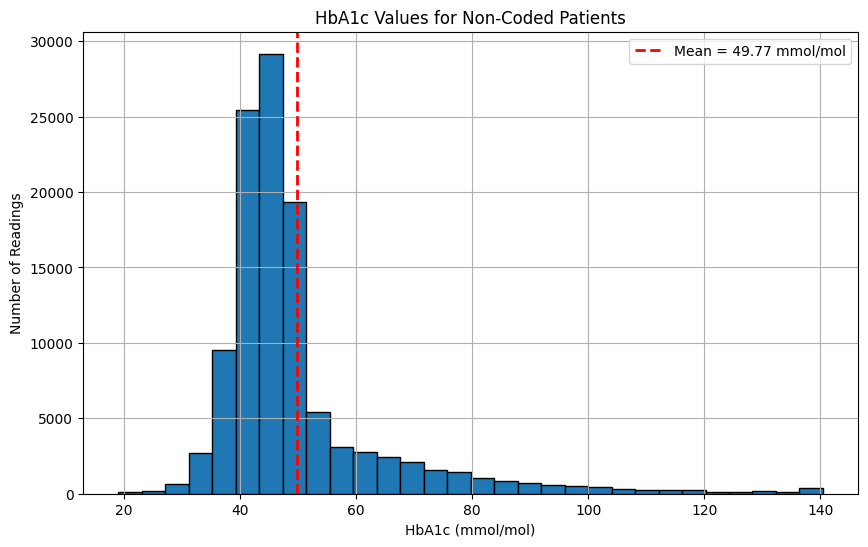

In [ ]:
filtered_hba1cs = hba1cs[hba1cs['PERSON_ID'].isin(non_coded_patients['PERSON_ID'])]

plt.figure(figsize=(10, 6))
plt.hist(filtered_hba1cs['RESULT_VALUE_CLEANED_AND_CONVERTED_TO_MMOL_PER_MOL'], bins=30, edgecolor='black')
plt.title('HbA1c Values for Non-Coded Patients')
plt.xlabel('HbA1c (mmol/mol)')
plt.ylabel('Number of Readings')
plt.grid(True)

_mean_val = filtered_hba1cs['RESULT_VALUE_CLEANED_AND_CONVERTED_TO_MMOL_PER_MOL'].mean()
plt.axvline(_mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {_mean_val:.2f} mmol/mol')

plt.legend()
plt.show()

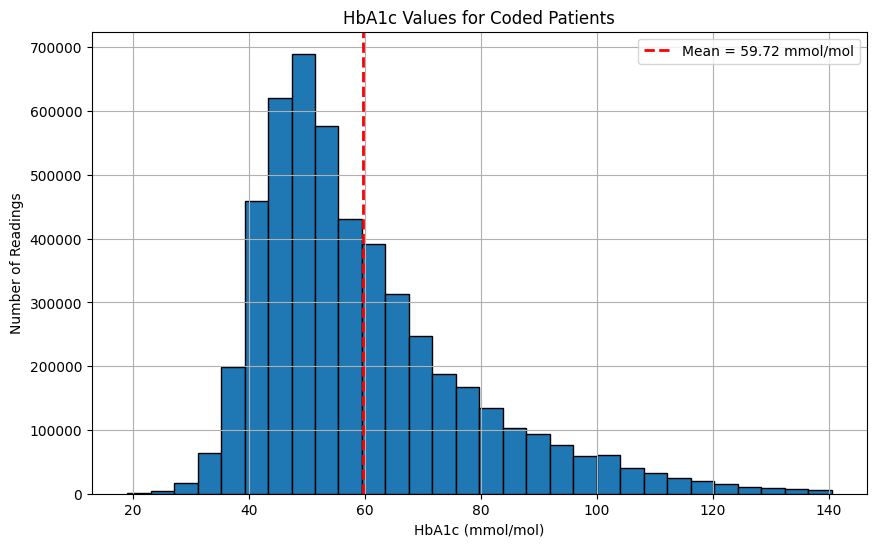

In [ ]:
hba1cs_coded_patients = hba1cs[hba1cs['PERSON_ID'].isin(coded_patients['PERSON_ID'])]

plt.figure(figsize=(10, 6))
plt.hist(hba1cs_coded_patients['RESULT_VALUE_CLEANED_AND_CONVERTED_TO_MMOL_PER_MOL'], bins=30, edgecolor='black')
plt.title('HbA1c Values for Coded Patients')
plt.xlabel('HbA1c (mmol/mol)')
plt.ylabel('Number of Readings')
plt.grid(True)

_mean_val = hba1cs_coded_patients['RESULT_VALUE_CLEANED_AND_CONVERTED_TO_MMOL_PER_MOL'].mean()
plt.axvline(_mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {_mean_val:.2f} mmol/mol')

plt.legend()
plt.show()

In [ ]:
"""
Based on the above, decided to make the HbA1c requirement stricter - need two successive HbA1cs >= 48 more than 2 weeks apart (to avoid repeat coded values counting)
"""

In [ ]:
with open('create_tables/patients_with_2_successive_hba1c_greater_than_equal_to_48.sql') as _fid:
    _query = _fid.read()
    # data = conn.session.sql(sql).collect()

feature_id = feature_store_manager.get_feature_id_from_table_name('PATIENTS_WITH_2_HBA1C_GREATER_THAN_EQUAL_TO_48_V1')
feature_store_manager.update_feature(feature_id=feature_id, new_sql_select_query=_query, change_description="Now require two successive HbA1cs >=48 (and must be more than 2 weeks apart)")

Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Updating feature PATIENTS_WITH_2_HBA1C_GREATER_THAN_EQUAL_TO_48, with ID 5a5df67a-78e1-489a-951c-0875fa720fc3


Using schema: AI_CENTRE_FEATURE_STORE


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE


Table PATIENTS_WITH_2_HBA1C_GREATER_THAN_EQUAL_TO_48_v2 created successfully


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE
Feature 5a5df67a-78e1-489a-951c-0875fa720fc3 version 2 added to the feature version registry


In [ ]:
two_hba1cs_v2 = conn.session.sql("""SELECT * FROM 
INTELLIGENCE_DEV.AI_CENTRE_FEATURE_STORE.PATIENTS_WITH_2_HBA1C_GREATER_THAN_EQUAL_TO_48_V2;
    """).to_pandas()

In [ ]:
print(f"Number of coded patients: {len(coded_patients):,}")
print(f"Number of patients with diabetic HbA1cs: {len(two_hba1cs_v2):,}")

Number of coded patients: 432,178
Number of patients with diabetic HbA1cs: 355,749


In [ ]:
with open('create_tables/patients_diagnosed_by_hba1c_but_not_coded_v2.sql') as _fid:
    _query = _fid.read()
    # data = conn.session.sql(sql).collect()

_feature_id = feature_store_manager.get_feature_id_from_table_name('PATIENTS_DIAGNOSED_BY_HBA1C_BUT_NOT_CODED_V1')
feature_store_manager.update_feature(feature_id=_feature_id, new_sql_select_query=_query, change_description="Now require two successive HbA1cs >=48 (and must be more than 2 weeks apart)")

Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Updating feature PATIENTS_DIAGNOSED_BY_HBA1C_BUT_NOT_CODED, with ID 1a574182-bdad-4c1d-815f-5d5798425f89


Using schema: AI_CENTRE_FEATURE_STORE


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE


Table PATIENTS_DIAGNOSED_BY_HBA1C_BUT_NOT_CODED_v2 created successfully


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE
Feature 1a574182-bdad-4c1d-815f-5d5798425f89 version 2 added to the feature version registry


In [ ]:
non_coded_patients_v2 = conn.session.sql("""SELECT * FROM INTELLIGENCE_DEV.AI_CENTRE_FEATURE_STORE.PATIENTS_DIAGNOSED_BY_HBA1C_BUT_NOT_CODED_V2;""").to_pandas()

print(f"Number of patients with diabetic HbA1cs but not coded as having diabetes: {len(non_coded_patients_v2):,}")

Number of patients with diabetic HbA1cs but not coded as having diabetes: 8,645


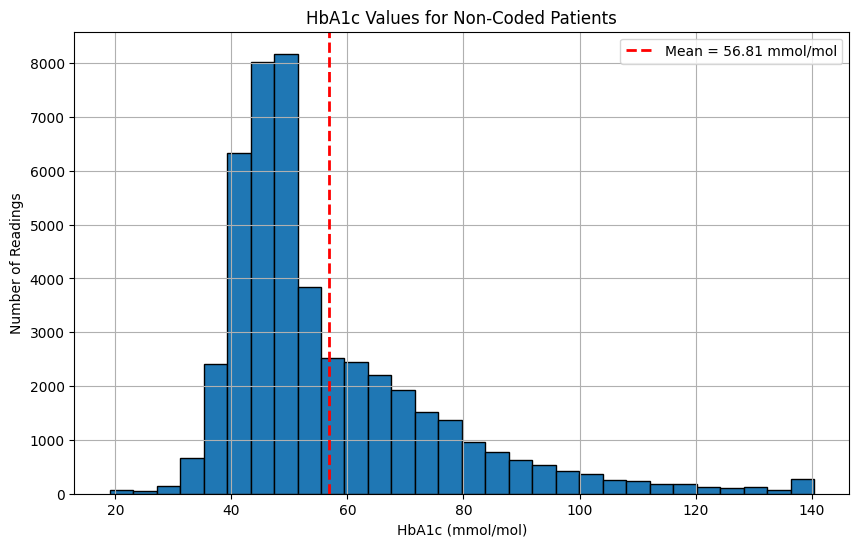

In [ ]:
filtered_hba1cs_v2 = hba1cs[hba1cs['PERSON_ID'].isin(non_coded_patients_v2['PERSON_ID'])]

plt.figure(figsize=(10, 6))
plt.hist(filtered_hba1cs_v2['RESULT_VALUE_CLEANED_AND_CONVERTED_TO_MMOL_PER_MOL'], bins=30, edgecolor='black')
plt.title('HbA1c Values for Non-Coded Patients')
plt.xlabel('HbA1c (mmol/mol)')
plt.ylabel('Number of Readings')
plt.grid(True)

_mean_val = filtered_hba1cs_v2['RESULT_VALUE_CLEANED_AND_CONVERTED_TO_MMOL_PER_MOL'].mean()
plt.axvline(_mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {_mean_val:.2f} mmol/mol')

plt.legend()
plt.show()

In [ ]:
"""
Discussed with Jordan and found out there are SNOMED resolved codes for a particular condition. Checked the database and there are a few diabetes resolved codes but only 1 in use. Need to look at (a) patients with diabetes resolved codes (b) how many of the selected patients have diabetes resolved codes
"""

In [ ]:
_fid = feature_store_manager.get_feature_id_from_table_name('PATIENTS_WITH_DIABETES_RESOLUTION_CODE_v1')
feature_store_manager.delete_feature(feature_id=_fid)

Using schema: AI_CENTRE_FEATURE_STORE_METADATA


Using schema: AI_CENTRE_FEATURE_STORE


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


[Row(TABLE_NAME='PATIENTS_WITH_DIABETES_RESOLUTION_CODE_V1')]


Using schema: AI_CENTRE_FEATURE_STORE
Deleting table PATIENTS_WITH_DIABETES_RESOLUTION_CODE_V1


Table PATIENTS_WITH_DIABETES_RESOLUTION_CODE_V1 deleted successfully


Using schema: AI_CENTRE_FEATURE_STORE_METADATA


In [ ]:
with open('create_tables/patients_with_diabetes_resolution_code.sql') as _fid:
    _query = _fid.read()
    # data = conn.session.sql(sql).collect()

feature_store_manager.add_new_feature(
    feature_name="patients_with_diabetes_resolution_code",
    feature_desc="""
        Patients who have a SNOMED code for diabetes resolved on their record
        """,
    feature_format="Mixed",
    sql_select_query_to_generate_feature=_query, )

Using schema: AI_CENTRE_FEATURE_STORE_METADATA


['IMD2019LONDON', 'PERSON_MASTER_INDEX', 'HBA1C_WITH_UNIT_REALLOCATION', 'PATIENTS_WITH_NON_T1DM_CODES_ALL_INSTANCES', 'PATIENTS_WITH_NON_T1DM_CODES', 'PATIENTS_WITH_2_HBA1C_GREATER_THAN_EQUAL_TO_48', 'PATIENTS_DIAGNOSED_BY_HBA1C_BUT_NOT_CODED', 'BMI_classification_all', 'PATIENTS_WITH_DIABETES_RESOLUTION_CODE']


<span class="codehilite"><div class="highlight"><pre><span></span><span class="gt">Traceback (most recent call last):</span>
  File <span class="nb">&quot;/Users/isobelweinberg/Documents/code/onelondon_snowflake_datascience/.venv/lib/python3.11/site-packages/marimo/_runtime/executor.py&quot;</span>, line <span class="m">142</span>, in <span class="n">execute_cell</span>
<span class="w">    </span><span class="k">return</span> <span class="nb">eval</span><span class="p">(</span><span class="n">cell</span><span class="o">.</span><span class="n">last_expr</span><span class="p">,</span> <span class="n">glbls</span><span class="p">)</span>
<span class="w">           </span><span class="pm">^^^^^^^^^^^^^^^^^^^^^^^^^^^</span>
  File <span class="nb">&quot;/var/folders/d_/zh_5_p357sz92r_9zhm0g01c0000gn/T/marimo_46023/__marimo__cell_SDpF_.py&quot;</span>, line <span class="m">5</span>, in <span class="n">&lt;module&gt;</span>
<span class="w">    </span><span class="n">feature_store_manager</spa

In [ ]:
# Need to add dates to 

In [ ]:
# TODO
# [x] which patients?
# [ ] what about patients coded as diabetic who are no longer diabetic?
# [ ] once have sorted that out, need to join together the two tables to get all diabetic patients and whether they were diagnosed by code or found by us
# [ ] Dan's tables - but Dan uses different HbA1c definition to me!
# [ ] hba1c trajectories
# [ ] final hba1c distribution
# [ ] age - distribution and relationship to final hba1c
# [ ] exclude certain hba1cs as per jordan
# [ ] need to plot/examine the units issue in more detail
# [ ] discuss hba1c selection with dan
# [ ] should probably round hba1cs to whole numbers to avoid false precision
# [ ] add marimo to requirements